In [1]:
import pymysql
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import plotly.graph_objects as go
import plotly.offline as pyo
from plotly.subplots import make_subplots
from datetime import timedelta
import scipy.stats as sps

In [2]:
#pip install holidays
import holidays

In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [4]:
conn = pymysql.connect(host='localhost', port=int(3306), user='root', passwd='spartandb', db='spartan')
cve = pd.read_sql_query('SELECT * FROM bastazo_common_vulnerabilityfromnvd', conn)
cpe = pd.read_sql_query('SELECT * FROM bastazo_common_cpe', conn)

## When are vulnerabilities most frequently disclosed?

In [35]:
data = cve[['published_date']]
data['day'] = data['published_date'].dt.day_name()
data['date'] = data['published_date'].dt.date
data['year'] = data['published_date'].dt.year
data.head()

,published_date,day,date,year
0,2019-11-21 15:15:00,Thursday,2019-11-21,2019
1,2019-11-21 15:15:00,Thursday,2019-11-21,2019
2,2019-11-21 15:15:00,Thursday,2019-11-21,2019
3,2019-11-20 21:15:00,Wednesday,2019-11-20,2019
4,2019-11-20 20:15:00,Wednesday,2019-11-20,2019


In [36]:
from pandas.api.types import CategoricalDtype
days = data[['day', 'date']]
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
cat_type = CategoricalDtype(categories=cats, ordered=True)
results = days.groupby(['day']).count().reindex(cats)
freq_day = results.rename(columns={'date':'count'}).reset_index()
freq_day

,day,count
0,Monday,14390
1,Tuesday,16387
2,Wednesday,19157
3,Thursday,16622
4,Friday,15631
5,Saturday,3638
6,Sunday,3835


In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x='day', y='count', data=freq_day)

In [ ]:
us_holidays = holidays.US()
data2 = data[['date', 'year']] 
results2 = data2.groupby(['date']).count().sort_values(by=['year'], ascending=False)
results2.rename(columns={'year':'count'}).reset_index()
top10 = results2[0:10].reset_index()
top10.rename(columns={'year':'count'}, inplace=True)
top10['day'] = pd.to_datetime(top10['date']).dt.day_name()
top10

## Exploit types and CWE clustering

In [7]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from datetime import timedelta
from sklearn.cluster import KMeans
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import PCA
import plotly.figure_factory as ff

In [8]:
cve = pd.read_csv('cve.csv', header=0, index_col=0)
vendors = pd.read_csv('vendors/vendors.csv', header=0, index_col=0)
products = pd.read_csv('products/products.csv', header=0, index_col=0)
vendor_product = pd.read_csv('vendor_product/vendor_product.csv', header=0, index_col=0)
cve.pub_date = pd.to_datetime(cve.pub_date)

In [9]:
K = 500
M = 100
L = 10
thresh = .01
cwes = pd.get_dummies(cve.cwe_name)
top_K = products.vulnerable_product.value_counts()[:K]
counts = top_K.values
X = products[products.vulnerable_product.isin(top_K.index)].join(cwes).groupby('vulnerable_product').sum()
# Normalize
X = X.divide(X.sum(axis=1), axis=0)
# Sparsify (to prevent big products from being clustered together by virtue of being big)
below_threshold = X < thresh
X[below_threshold] = 0
Z = KernelPCA(n_components=2, kernel="cosine").fit_transform(X)

In [10]:
fig = go.Figure()
fig.add_trace(go.Scatter(
        x=Z[:,0][L:M],
        y=Z[:,1][L:M],
        mode="markers",
        text=top_K.index[L:M],
        marker=dict(
            size=2 * np.sqrt(counts[L:M]),
            color='#bbbbbb',
            showscale=False)))
fig.add_trace(go.Scatter(
        x=Z[:,0][:L],
        y=Z[:,1][:L],
        mode="markers+text",
        text=np.vectorize(lambda x: " ".join(map(lambda x: x.title() if len(x) > 2 else x.upper(), x.split("_"))))(top_K.index[:L]),
        textposition = "top center",
        marker=dict(
            size=2 * np.sqrt(counts[:L]),
            color='#93a1a1',
            showscale=False ) ))
fig.update_layout(height=800,showlegend=False,title=dict(text="Plotting products using exploit types",xref="paper",x=0., y=1.),
    font=dict(family="Arial",size=14,color="#586e75"),
    xaxis=dict(showgrid=False,showticklabels=False),
    yaxis=dict(showgrid=False,showticklabels=False),
    annotations=[dict(xref='paper',yref='paper',x=0., y=1.1,showarrow=False,
            text ="All products are projected into two dimensions using KernelPCA with cosine similarity as the chosen kernel.<br>" + 
            "Products are sized proportionally to the how many CVE entries affect a given product. The top 10 products<br>are labelled, the top 100 are projected.",
            valign='top',
            align='left'),],
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    bargap=0
)
fig.show(renderer="iframe")

In [11]:
fig = go.Figure()
solarized_colors = ['#dc322f', '#6c71c4', '#268bd2', '#2aa198', '#073642']
V = vendors.vendor.value_counts()[5:0:-1].index
top_K_vp = top_K.reset_index().join(vendor_product.set_index('product'), on='index')
ndxs = top_K_vp[~top_K_vp.vendor.isin(V)].index
fig.add_trace(
    go.Scatter(
        x=Z[:,0][ndxs],
        y=Z[:,1][ndxs],
        mode="markers",
        name='others',
        text=np.vectorize(lambda x: " ".join(map(lambda x: x.title() if len(x) > 2 else x.upper(), x.split("_"))))(top_K.index[ndxs]),
        marker=dict(
            size=2 * np.sqrt(counts[ndxs]),
            color='#dddddd',
            showscale=False,)))
for ndx, vendor in enumerate(V):
    ndxs = top_K_vp[top_K_vp.vendor == vendor].index
    fig.add_trace(
        go.Scatter(
            x=Z[:,0][ndxs],
            y=Z[:,1][ndxs],
            mode="markers",
            name=vendor,
            text=np.vectorize(lambda x: " ".join(map(lambda x: x.title() if len(x) > 2 else x.upper(), x.split("_"))))(top_K.index[ndxs]),
            marker=dict(
                size=2 * np.sqrt(counts[ndxs]),
                color=solarized_colors[ndx],
                showscale=False,)))
fig.update_layout(legend=dict(x=0., y=1.),height=800,title=dict(text="Visualizing vendors",xref="paper",x=0., y=1.),
    font=dict(family="Arial",size=14,color="#586e75"),
    xaxis=dict(showgrid=False,showticklabels=False),
    yaxis=dict(showgrid=False,showticklabels=False),
    annotations=[dict(xref='paper',yref='paper',x=0., y=1.1,showarrow=False,
            text ="Vendors are one inherent clustering already present in the data. Here's how KernelPCA with<br>cosine similarity distributes products from the top 5 vendors.",
            valign='top',
            align='left'),],
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)')
    
fig.show(renderer='iframe')

## Vulnerability to source analysis

In [12]:
cve2src = pd.read_csv('cve2source.csv')
stats = cve2src.groupby('source').agg('count').pipe(pd.DataFrame).rename(columns={'cve':'frequency'})
stats['percent'] = (stats['frequency']/sum(stats['frequency'])*100)
stats= stats.reset_index()
stats.sort_values(by=['percent'], ascending=False, inplace=True)
stats.head(10)

,source,frequency,percent
68,MITRE,26170,43.616667
72,Microsoft Corporation,3500,5.833333
87,Oracle,2954,4.923333
54,IBM Corporation,2054,3.423333
21,"Cisco Systems, Inc.",2023,3.371667
5,Android (associated with Google Inc. or Open H...,1766,2.943333
1,Adobe Systems Incorporated,1600,2.666667
7,Apple Inc.,1423,2.371667
93,"Qualcomm, Inc.",1363,2.271667
95,"Red Hat, Inc.",1354,2.256667


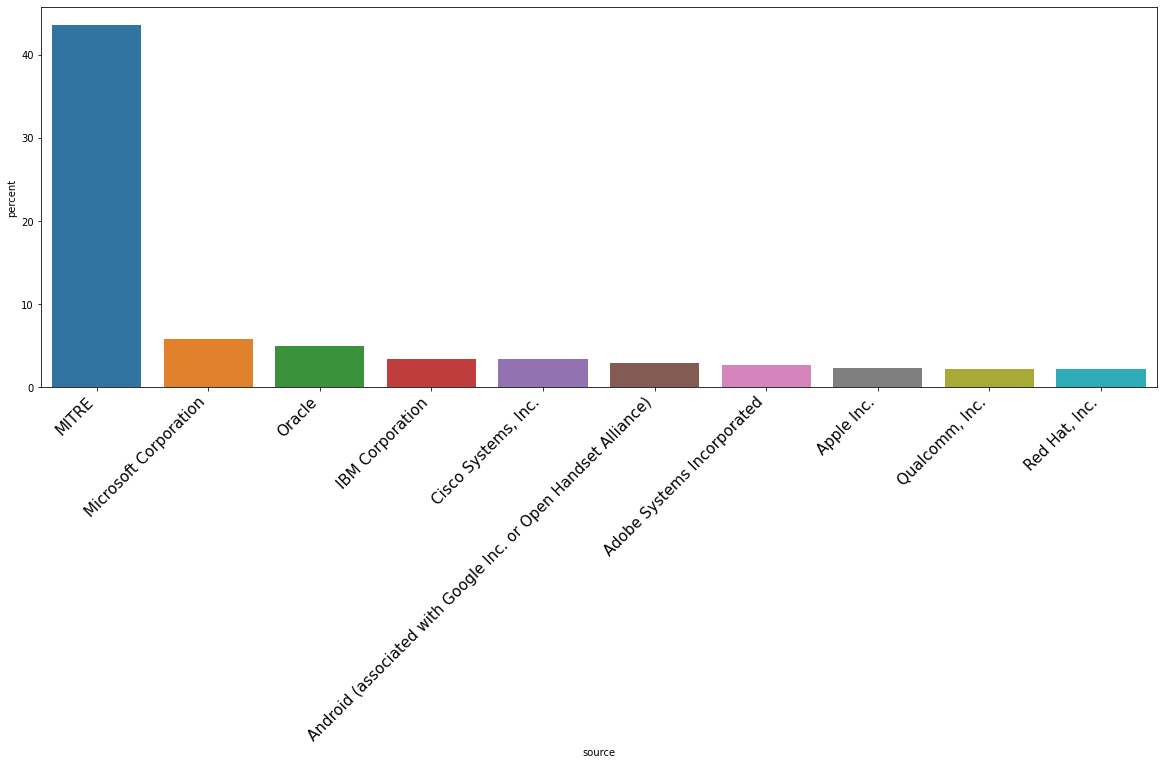

In [13]:
plt.figure(figsize=(20, 7))
chart = sns.barplot(data=stats[0:10], x='source', y='percent')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=15)
None

## CVE growth rate based on Publication Date

In [14]:
cve_loc = pd.read_csv('cve.csv')
cve_loc.pub_date = pd.to_datetime(cve_loc.pub_date)
cve_loc.rename(columns={'Unnamed: 0':'cve_id', 'pub_date':'published_date', 'cvss':'cvss_base_score'}, inplace=True)
cve_loc.published_date = pd.to_datetime(cve_loc.published_date)
data_loc = cve_loc[['cve_id', 'published_date']]
data_loc['published_date'] = pd.to_datetime(data_loc['published_date'].dt.date)
data_loc.head()

,cve_id,published_date
0,CVE-2019-16548,2019-11-21
1,CVE-2019-16547,2019-11-21
2,CVE-2019-16546,2019-11-21
3,CVE-2013-2092,2019-11-20
4,CVE-2013-2091,2019-11-20


In [39]:
data = cve[['cve_id', 'published_date']]

In [40]:
data.head()

,cve_id,published_date
0,CVE-2019-16548,2019-11-21 15:15:00
1,CVE-2019-16547,2019-11-21 15:15:00
2,CVE-2019-16546,2019-11-21 15:15:00
3,CVE-2013-2092,2019-11-20 21:15:00
4,CVE-2013-2091,2019-11-20 20:15:00


In [41]:
data_final = pd.concat([data, data_loc]).drop_duplicates().reset_index(drop=True)
data_final.published_date = pd.to_datetime(data_final.published_date)

## CVE growth rate based on Publication Date

In [42]:
X = data_final.published_date.dt.to_period('Q').sort_index().value_counts()
X.index = X.index.to_timestamp()
X = X.sort_index()
X[X.index] = np.cumsum(X.values)

rolling = data_final.published_date.dt.to_period('M').sort_index().value_counts()
rolling.index = rolling.index.to_timestamp()
rolling = rolling.sort_index()
rolling[rolling.index] = np.cumsum(rolling.values)
rolling = rolling.rolling(12, axis=0).sum().pct_change(axis=0)

fig = make_subplots(rows=1, cols=2)
# Trace 1: Grey bars
fig.add_trace(go.Bar(x=X.index[:-20],y=X.values[:-20],marker_color="#bbbbbb",),row=1,col=1)
# Trace 2: Blue (emph) bars
fig.add_trace(go.Bar(x=X.index[-20:],y=X.values[-20:],marker_color="#2aa198"), row=1,col=1)
# Trace 3: Growth rate
#fig.add_trace(go.Scatter(x=rolling.index,y=rolling.values,marker_color="#bbaabb",mode="lines"),row=1,col=2)
fig.update_layout(title=dict(text="Threat Proliferation",xref="paper",x=0., y=1.),
                  font=dict(family="Arial",size=14,color="#586e75"),
                  xaxis=dict(showgrid=False),yaxis=dict(showgrid=False),
                  annotations = [ dict(xref='paper',yref='paper',x=0., y=1.2,showarrow=False,
                                  text ='The number of known threats (left) continues to grow and 60% overall CVE reported in last 6 years',
            valign='top',
            align='left'
        ),
                      dict(ax=-80,ay=-100,x=X.index[-20],y=40000,text='60% of threats occur after 2015')],
                  showlegend=False,paper_bgcolor='rgba(0,0,0,0)',plot_bgcolor='rgba(0,0,0,0)',bargap=0
                )
fig.show(renderer="iframe")


## What is the severity distribution of vulnerabilities?

In [21]:
data_loc = cve_loc[['cve_id', 'cvss_base_score']]
data_remo = cve[['cve_id', 'cvss_base_score']]
data_final = pd.concat([data_loc, data_remo]).drop_duplicates().reset_index(drop=True)

<AxesSubplot:xlabel='cvss_base_score', ylabel='Count'>

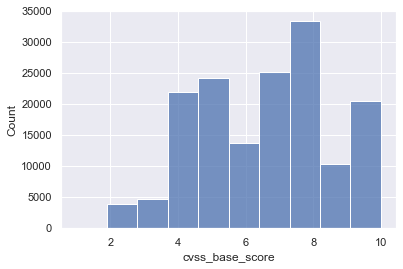

In [22]:
sns.set_theme(style='darkgrid')
sns.histplot(data=data_final, x='cvss_base_score', bins=10, binrange=(1,10))

In [24]:
fig = go.Figure()
X = data_final.cvss_base_score.sort_values().astype('int').value_counts().sort_index()[1:]
# Three traces
fig.add_trace(go.Bar(x=X.index.map(lambda x: "{}-{}".format(x-1,x)),
            y=X.values/np.sum(X.values)*100,
            marker_color=['#bbbbbb', '#add8e6', '#add8e6', '#ffa500', '#ffa500', '#ffa500', '#ffa500', '#dc322f', '#dc322f', '#8b0000'],
            text=np.vectorize(lambda x: str(x) + "%")(np.round((X.values/np.sum(X.values) * 100),1)),
            textposition='outside'))
fig.update_layout(
    title=dict(text="Threat Severity Distribution",xref="paper",x=0., y=1.),
    font=dict(family="Arial",size=14,color="#586e75"),
    xaxis=dict(showgrid=False,),
    yaxis=dict(showgrid=False,showticklabels=False),
    annotations=[dict(xref='paper',yref='paper',x=0., y=1.2,showarrow=False,
            text ="CVSS scores reflect a threat's severity. Over 75 percent of scores fall in FIRSTs Medium (4.0-6.9) threat category<br>" +
            "with a thicker tail toward the higher end of the spectrum.",
            valign='top',align='left'),],
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    bargap=0
)
fig.show(renderer='iframe')

## Vulnerability impact trends

In [25]:
cve = cve_loc
# Authentication Access
single = pd.get_dummies(cve.access_authentication.dropna()).groupby(cve.published_date.dt.to_period('Y')).mean().SINGLE
none = pd.get_dummies(cve.access_authentication.dropna()).groupby(cve.published_date.dt.to_period('Y')).mean().NONE

# Access required
low = pd.get_dummies(cve.access_complexity.dropna()).groupby(cve.published_date.dt.to_period('Y')).mean().LOW
med = pd.get_dummies(cve.access_complexity.dropna()).groupby(cve.published_date.dt.to_period('Y')).mean().MEDIUM
high = pd.get_dummies(cve.access_complexity.dropna()).groupby(cve.published_date.dt.to_period('Y')).mean().HIGH

# Attack vector
net = pd.get_dummies(cve.access_vector.dropna()).groupby(cve.published_date.dt.to_period('Y')).mean().NETWORK
loc = pd.get_dummies(cve.access_vector.dropna()).groupby(cve.published_date.dt.to_period('Y')).mean().LOCAL
adj = pd.get_dummies(cve.access_vector.dropna()).groupby(cve.published_date.dt.to_period('Y')).mean().ADJACENT_NETWORK

# Impact on Availability
part = pd.get_dummies(cve.impact_availability.dropna()).groupby(cve.published_date.dt.to_period('Y')).mean().PARTIAL
no_ia = pd.get_dummies(cve.impact_availability.dropna()).groupby(cve.published_date.dt.to_period('Y')).mean().NONE
comp = pd.get_dummies(cve.impact_availability.dropna()).groupby(cve.published_date.dt.to_period('Y')).mean().COMPLETE

# Impact on Confidentiality
part_ic = pd.get_dummies(cve.impact_confidentiality.dropna()).groupby(cve.published_date.dt.to_period('Y')).mean().PARTIAL
no_ic = pd.get_dummies(cve.impact_confidentiality.dropna()).groupby(cve.published_date.dt.to_period('Y')).mean().NONE
comp_ic = pd.get_dummies(cve.impact_confidentiality.dropna()).groupby(cve.published_date.dt.to_period('Y')).mean().COMPLETE

# Impact on Integrity
part_ii = pd.get_dummies(cve.impact_integrity.dropna()).groupby(cve.published_date.dt.to_period('Y')).mean().PARTIAL
no_ii = pd.get_dummies(cve.impact_integrity.dropna()).groupby(cve.published_date.dt.to_period('Y')).mean().NONE
comp_ii = pd.get_dummies(cve.impact_integrity.dropna()).groupby(cve.published_date.dt.to_period('Y')).mean().COMPLETE

In [26]:
traces = [[single, none],[low, med, high],[net, loc, adj],[part, no_ia, comp],[part_ic, no_ic, comp_ic],[part_ii, no_ii, comp_ii],]
texts = [['Single', 'None'],['Low', 'Medium', 'High'],['Network', 'Local', 'Adj. Network'],['Partial', 'None', 'Complete'],
    ['Partial', 'None', 'Complete'],['Partial', 'None', 'Complete'],]
colors = ['#2aa198', '#268bd2', '#dc322f']

In [27]:
fig = make_subplots(rows=3, cols=2, 
    subplot_titles=[
        'Authentication required',
        'Impact on availability',
        'Access required',
        'Impact on confidentiality',
        'Attack vector',
        'Impact on integrity'
])
for i, (t, txt) in enumerate(zip(traces, texts)):
    for ndx, trace in enumerate(t):
        fig.add_trace(go.Scatter(x = [trace.index.to_timestamp()[-1]],y = [trace[-1]],name = "",
                                 text = " {}% {}".format(np.round(trace[-1] * 100, 1), txt[ndx]),
                                 textposition='middle right',mode='text',cliponaxis=False),row=i%3 + 1,col=i//3 + 1,)
        fig.add_trace(
             go.Scatter(
                x = trace.index.to_timestamp(),
                y = trace,
                name = "",
                line=dict(color=colors[ndx])
            ),
            row=i%3 + 1,
            col=i//3 + 1
        )

        fig.add_trace(
            go.Scatter(
                x = [trace.index.to_timestamp()[0]],
                y = [trace[0]],
                name = "",
                text = "{}% ".format(np.round(trace[0] * 100), 1),
                textposition='middle left',
                mode='text',
                cliponaxis=False
            ),
            row=i%3 + 1,
            col=i//3 + 1
            )

fig.update_layout(showlegend=False,height=1200,title=dict(text="Access and impact",),
    font=dict(family="Arial",size=12,color="#586e75"),
    xaxis=dict(showgrid=False,),
    yaxis=dict(showgrid=False,showticklabels=False),
    yaxis2=dict(showgrid=False,showticklabels=False),
    yaxis3=dict(showgrid=False,showticklabels=False),
    yaxis4=dict(showgrid=False,showticklabels=False),
    yaxis5=dict(showgrid=False,showticklabels=False),
    yaxis6=dict(showgrid=False,showticklabels=False),
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)
fig.show(renderer='iframe')


## Exploitability Analysis - How threats have changed over time

In [28]:
plt.figure(figsize=(10,5))
fig = go.Figure()

X = pd.get_dummies(cve.cwe_name[cve.cwe_name.isin(cve.cwe_name.value_counts()[:10].index)]).join(cve_loc.published_date).groupby(cve_loc.published_date.dt.to_period("D")).sum()
colors = ['#ababab', '#cb4b16', '#268bd2', '#ebebeb', '#2aa198', '#dc322f', '#bbbbbb', '#9b9b9b', '#cbcbcb', '#dbdbdb']
X.index = X.index.to_timestamp()
X = X.divide(X.sum(axis=1), axis=0)
# One trace for each column
for ndx in range(X.shape[1]):
    data = X.iloc[:,ndx].rolling(365,axis=0).mean() 
    fig.add_trace(go.Scatter(

        x=data.index[365:],
        y=data.values[365:], 
        name=X.columns[ndx] if "'" not in X.columns[ndx] else X.columns[ndx].split("'")[1],
        marker_color=colors[ndx]
    ))
    fig.update_layout(title=dict(text="How threats have changed over time",xref="paper",x=0., y=1.),height=920,
                      font=dict(family="Arial",size=14,color="#586e75"),
                      xaxis=dict(showgrid=False,),
                      yaxis=dict(showgrid=False,showticklabels=False),
                      annotations=[dict(xref='paper',yref='paper',x=0., y=1.075,showarrow=False,
                                   text ="These threats are the 10 most common, but their relative prominence is shifting, injection (code and SQL)<br>" + 
                                         " is becoming less common while cross-site scripting and input validation are on the rise. " +
                                         "Values are shown as <br> a 365-entry rolling average of relative frequencies.",
                                    valign='top',align='left'),],
                      paper_bgcolor='rgba(0,0,0,0)',
                      plot_bgcolor='rgba(0,0,0,0)',
                      legend=dict(x=0., y=1.))
fig.show(renderer='iframe')


<Figure size 720x360 with 0 Axes>

## Vulnerable Products and Vendor Analysis

In [29]:
conn = pymysql.connect(host='localhost', port=int(3306), user='root', passwd='spartandb', db='spartan')
cpe = pd.read_sql_query('SELECT * FROM bastazo_common_cpe', conn)

In [30]:
cpe_data = cpe[['vendor', 'product']]
cpe_final = cpe_data.drop_duplicates().reset_index(drop=True)

## Top 20 vendors by product count

In [31]:
X = cpe_final.vendor.value_counts()[0:20]
X.sort_values(ascending=True, inplace=True)

fig = go.Figure()
fig.add_trace(go.Bar(
    y=np.vectorize(lambda x: " ".join(map(lambda x: x.title() if len(x) > 3 else x.upper(), x.split("_"))))(X.index),
    x=X.values,
    orientation='h',
    marker_color= "#889900"
))
fig.update_layout(height=800,
    title=dict(xref='paper',text="Top 20 CPE Vendors by product count",x=0, y=.965),
    font=dict(family="Arial",size=14,color="#586e75"),
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False,tickmode="linear"),
    annotations=[dict(xref='paper',yref='paper',x=0., y=1.075,showarrow=False,
                      text="40% of the products are distributed among these top 20 vendors",
            valign='top',
            align='left'),],
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    bargap=.2
)
fig.show(renderer='iframe')

## Top 20 Vendors by CVE count

In [32]:
products = pd.read_csv('./products/products.csv', header=0, index_col=0)
vendors = pd.read_csv('./vendors/vendors.csv', header=0, index_col=0)

In [33]:
X = vendors.vendor.value_counts()[0:20]
X.sort_values(ascending=True, inplace=True)
fig = go.Figure()
fig.add_trace(go.Bar(
    y=np.vectorize(lambda x: " ".join(map(lambda x: x.title() if len(x) > 3 else x.upper(), x.split("_"))))(X.index),
    x=X.values,
    orientation='h',
    marker_color= "#268bd2"
))
fig.update_layout(height=800,
    title=dict(xref='paper',text="Top 20 Affected Vendors",x=0, y=.965),
    font=dict(family="Arial",size=14,color="#586e75"),
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False,tickmode="linear"),
    annotations=[dict(xref='paper',yref='paper',x=0., y=1.075,showarrow=False,
                      text="50% of the products affected by any vulnerability are distributed among these top 20 vendors",
            valign='top',
            align='left'),],
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    bargap=.2
)
fig.show(renderer='iframe')

## Top 25 Affected products

In [34]:
X = products.vulnerable_product.value_counts()[25:0:-1]

fig = go.Figure()
fig.add_trace(go.Bar(
    y=np.vectorize(lambda x: " ".join(map(lambda x: x.title() if len(x) > 2 else x.upper(), x.split("_"))))(X.index),
    x=X.values,
    orientation='h',
    marker_color= ["#268bd2"] * 3 + ["#bbbbbb"] + ["#268bd2"] * 5 + ["#859900"] + ["#268bd2"] + ["#859900"] + ["#268bd2"] * 2 + ["#bbbbbb"] * 2 + ["#268bd2"] * 2 + ["#859900"] * 2 + ["#268bd2"] * 5
))
fig.update_layout(height=800,
                  title=dict(xref='paper',text="Affected Products",x=0, y=.965),
                  font=dict(family="Arial",size=14,color="#586e75"),
                  xaxis=dict(showgrid=False),
                  yaxis=dict(showgrid=False,tickmode="linear"),
                  annotations=[dict(xref='paper',yref='paper',x=0., y=1.075,showarrow=False,
                                text="Most of the top 25 affected products are operating systems (blue) or web browsers (green)",
                                valign='top',align='left'),],
                  paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)',
                  bargap=.2)
fig.show(renderer='iframe')
